# Satellite observations completeness for hydrological modelling

Production date: 12-07-2024

Produced by: Cristina Deidda (VUB)

## Use case: Integrating satellite soil moisture data into catchment-scale hydrological models for flood prediction

## Quality assessment question
* **Is the satellite soil moisture data sufficiently complete in spatial coverage to be considered suitable for integration into hydrological models?**


**Satellite soil moisture data can be used for different applications, one of the most common is hydrological models. The practice this analysis imply the selection of a specific catchment area and use the soil moisture data for each grid cell or averaging this values in the whole basin. For this type of application, it is essential to have a complete, or almost complete, data series in each cell. In this Case Study, we computed the percentage of missing values for each grid cell to highlight the completeness of data series and which area can be more or less suitable for this purpose. From the results we can see that the satellite soil moisture data are not complete, the spatial completeness of data vary for each continent. Considering the time interval of 1997-2002 there is a total of 37.7 % of world inland area with no data available. Nevertheless, there are different area in Europe in which the series is complete. Satellite soil moisture data have a great potential of being used as input of hydrological models, it has to be checked in advance the data availability and series completeness for the specific basin.**

## Quality assessment statement

Satellite data are not uniformly available in terms of both time and spatial coverage, with variations across continents. It is crucial to assess the completeness of the dataset for the specific area and timeframe under analysis before conducting any in-depth studies. In the specified time range of 1997-2002, approximately 37.8% of the world’s inland areas lack satellite data. Areas with dense vegetation (tropical, boreal forests), strong topography (mountains), ice cover (Greenland, Antarctica, Himalayas), a large fractional coverage of water, or extreme desert areas are masked since it was not possible to retrieve meaningful soil moisture retrievals (see Table 14 of PUGS). These areas are that one that have 100%  of missing values in Figure 1.
Quality flags are provided for daily data, giving information for each pixel about: frozen soils, dense vegetation, no convergence in retrieval, physical bounds exceeded, weights of measurements below threshold, all datasets unreliable, barren ground.

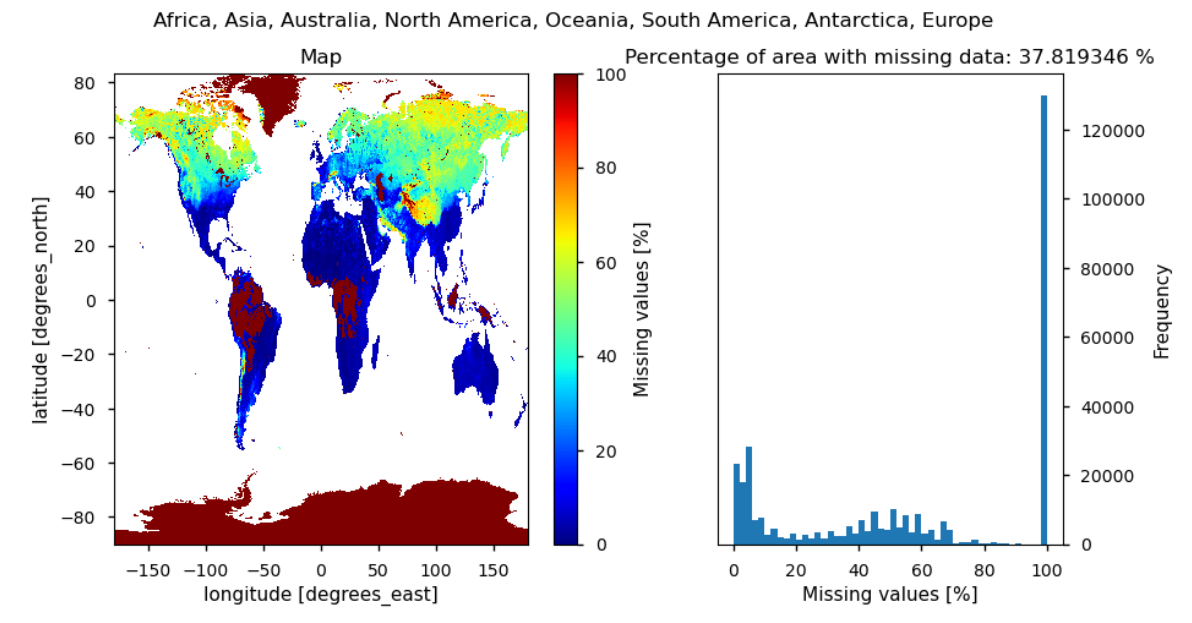

The coverage is better in Europe, South Africa and the continental US than some in other parts of the world as well as the improvement in the availability of data as new sensors became available. Moreover, there is spatial variability in data availability among continents. For instance, the entire African continent has a 13% data gap, primarily concentrated in its central region, while South America exhibits a higher data deficiency, with 35.6% of its areas lacking data.  The product behaves as expected because the satellites follow paths that provide more coverage around the equator. In the boreal (northern) and tropical regions, the coverage is lower, which is normal because we expect high VOD (Vegetation Optical Depth) in these areas. Additionally, in the far northern regions, snow and ice cover the ground for long periods, which also reduces satellite coverage in these areas. These results refers to 'active' sensors and monthly aggregation. Similar results are found with mixed sensors for the period (2015-2020), see Section 4.4 of PQDA.

Generally, considering specific areas of the world, the dataset can be used for hydrological or modelling applications, such as isolating single basins and studying soil moisture variations over time in the overall catchment area. We recommend conducting a preliminary pixel-level analysis to evaluate data completeness before commencing any detailed analysis. It is evident from the map that certain areas of the globe possess more complete datasets, making them more suitable for this type of analysis than other regions.

Key notes:

* The completeness of satellite soil moisture data varies for each continent
* For areas with dense vegetation (tropical, boreal forests), strong topography (mountains), ice cover (Greenland, Antarctica, Himalayas), a large fractional coverage of water, or extreme desert areas we are not able to make meaningful soil moisture retrievals. Hence, they are masked (there is no data available)
*  Satellites follow paths that provide more coverage around the equator. In the boreal (northern) and tropical regions, the coverage is lower, which is normal because we expect high VOD (Vegetation Optical Depth) in these areas. Additionally, in the far northern regions, snow and ice cover the ground for long periods, which also reduces satellite coverage in these areas
* Quality flags are available for daily data
* Check the availability of data and percentage of missing values before using it for hydrological applications


## Methodology
The analysis and results are organised in the following steps, which are detailed in the sections below: 

**[](section-1)**
 * Download surface soil moisture for the period 1997-2002

**[](section-2)**
 * Calculating percentage of missing values for each pixel

**[](section-3)**
 * Plot the map of percentage of missing values for each pixel and for a selected continent
 * Plot the histogram of percentage of missing values for the entire globe and for a selected continent

## Analysis and results

(section-1)=
### 1. Data request and download

### Import packages

Import the packages to download the data using the c3s_eqc_automatic_quality_control library and the packages to clip the dataframe with shapefile to extract inland data (geopanda, shapely.geometry)


In [2]:
import fsspec
import os
import geopandas
import matplotlib.pyplot as plt
import shapely.geometry
from c3s_eqc_automatic_quality_control import download

plt.style.use("seaborn-v0_8-notebook")



### Set variables

Define the starting and ending year of the analysis. Donwload world shapefile.

In [3]:
year_start = 1997
year_stop = 2002

shapefile_url = "https://figshare.com/ndownloader/files/23392280"

### Set the data request

Set the data request for satellite soil moisture data, specifing the version and type of record required.

In [4]:
collection_id = "satellite-soil-moisture"
request = {
    "variable": "surface_soil_moisture",
    "type_of_sensor": "active",
    "time_aggregation": "month_average",
    "year": [str(year) for year in range(year_start, year_stop + 1)],
    "month": [f"{month:02d}" for month in range(1, 12 + 1)],
    "day": "01",
    "type_of_record": "cdr",
    "version": "v202212",
}

### Download data

Download the data

In [5]:
# Dataset
ds = download.download_and_transform(
    collection_id,
    request,
    chunks={"year": 1},
    transform_chunks=False,
)


# Shapefile
with fsspec.open(f"simplecache::{shapefile_url}") as file:
    world_shape = geopandas.read_file(file)

100%|██████████| 6/6 [00:04<00:00,  1.43it/s]
/data/common/miniforge3/envs/wp5/lib/python3.11/site-packages/pyogrio/geopandas.py:261: UserWarning: More than one layer found in '5ad04ea5b97d47d3a6d5a5641225594d.zip': 'Continents' (default), 'Africa', 'North America', 'Europe', 'Oceania', 'South America', 'Asia', 'Antarctica', 'Australia'. Specify layer parameter to avoid this warning.
  result = read_func(


(section-2)=
## 2. Define function to compute missing values count and plot

### Define missing values function

Function that calculate for each grid cell the number of NA values for the entire time period selected

In [6]:
def compute_missing_values_count(ds):
    ds.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)
    ds.rio.write_crs("epsg:4326", inplace=True)

    da_mvc = ds["sm"].isnull().sum("time") / ds.sizes["time"] * 100
    da_mvc.attrs["long_name"] = "Missing values"
    da_mvc.attrs["units"] = "%"

    return da_mvc.to_dataset(name="mvc")

### Define plotting function

Define plotting function to visualize the world map with percentage of missing values and the histogram to know how many pixels have 100% of missing values respect to the total number of pixels.

In [7]:
def imshow_and_hist(da, shape):
    """Plot map and histogram side-by-side.

    Parameters
    ----------
    da: DataArray
        DataArray to plot
    shape: GeoDataFrame
        Geopandas object with polygons

    Returns
    -------
    figure, axes
    """
    fig, (ax_imshow, ax_hist) = plt.subplots(
        1, 2, figsize=[10, 5], gridspec_kw={"width_ratios": [3, 2]}
    )

    da = da.rio.clip(
        shape.geometry.apply(shapely.geometry.mapping),
        shape.crs,
        drop=True,
    )
    da.plot.imshow(ax=ax_imshow, cmap='jet')
    ax_imshow.set_title("Map")

    da.plot.hist(bins=50, ax=ax_hist)
    ax_hist.set_ylabel("Frequency")
    ax_hist.yaxis.set_label_position("right")
    ax_hist.yaxis.tick_right()

    # Compute and show no data percentage
    missing_data_perc = (da == 100).sum() / da.notnull().sum() * 100
    ax_hist.set_title(
        f"Percentage of area with missing data: {float(missing_data_perc):f} %"
    )

    fig.suptitle(", ".join(list(shape.CONTINENT)))
    return fig, (ax_imshow, ax_hist)

(section-3)=
## 3. Results visualization

### Plot world

Visualize on overview of the percentage of missing values for each pixel.

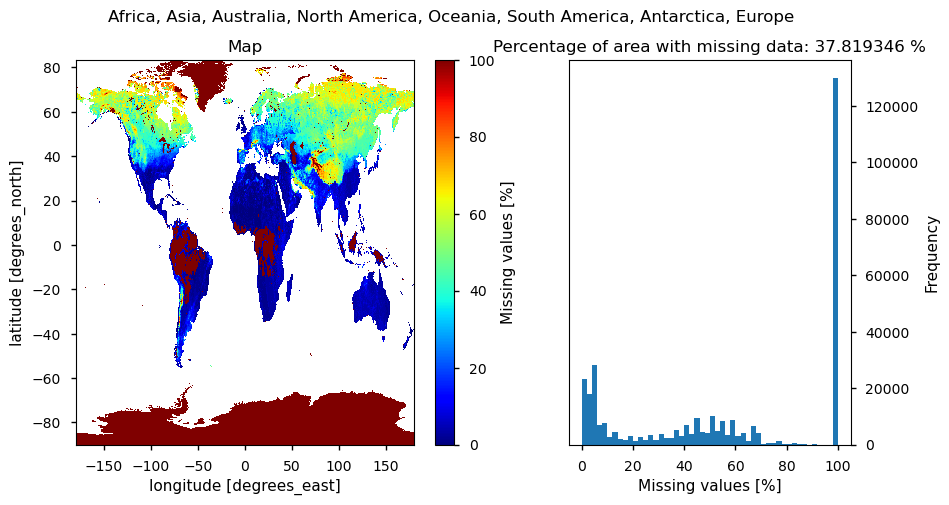

In [8]:
ds_misvalue= compute_missing_values_count(ds)
fig, axes = imshow_and_hist(ds_misvalue["mvc"], world_shape)

### Plot continents

Focus on a specific continent.

(<Figure size 1000x500 with 3 Axes>,
 (<Axes: title={'center': 'Map'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
  <Axes: title={'center': 'Percentage of area with missing data: 4.835917 %'}, xlabel='Missing values [%]', ylabel='Frequency'>))

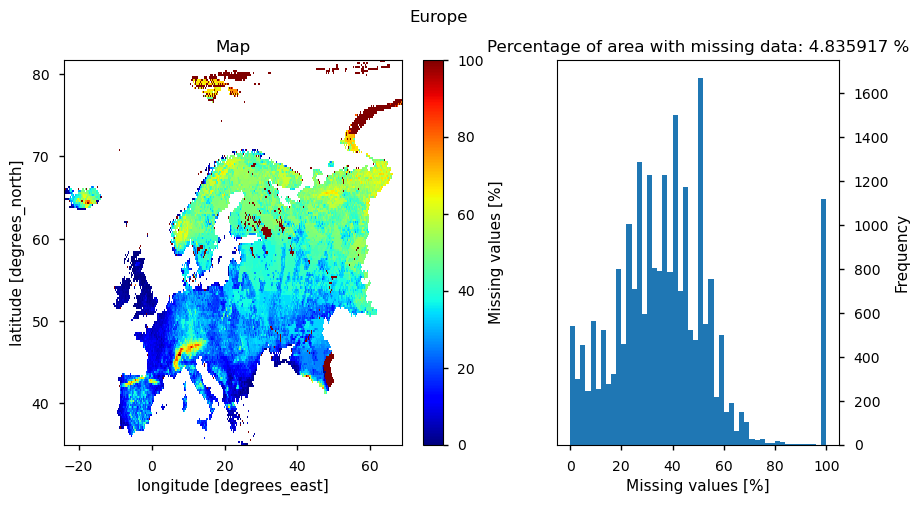

In [13]:
imshow_and_hist(ds_misvalue["mvc"], world_shape[world_shape.CONTINENT == "Europe"])